In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
seed=1710

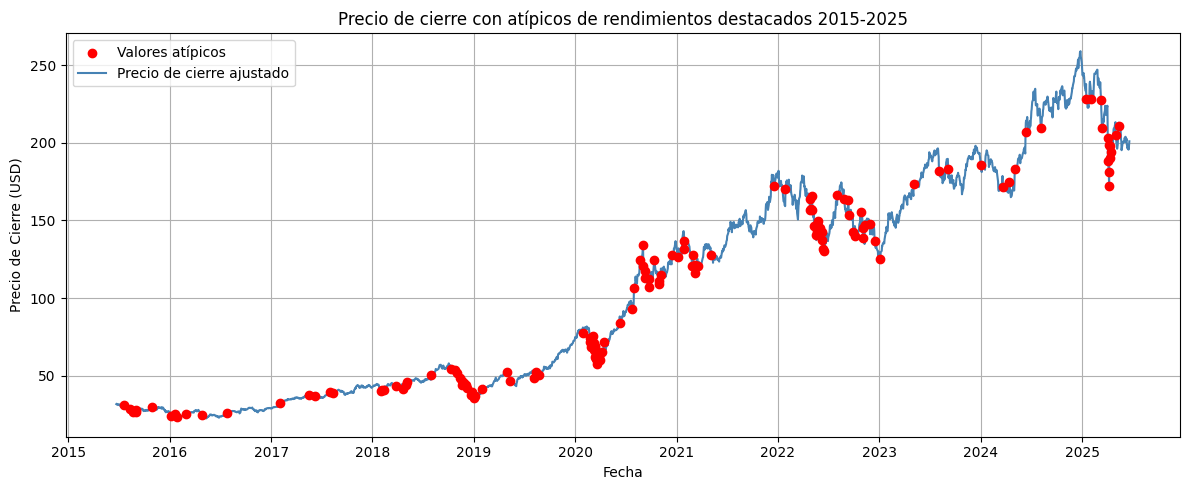

In [1]:
from modelo import CotizacionHistorica
from graficos import GraficosCotizaciones
historico = CotizacionHistorica("data/aapl_10y.csv")
graficos = GraficosCotizaciones(historico)
df = historico.cotizaciones(historico.fecha_min(), historico.fecha_max())
graficos.evolucion_cotizacion()

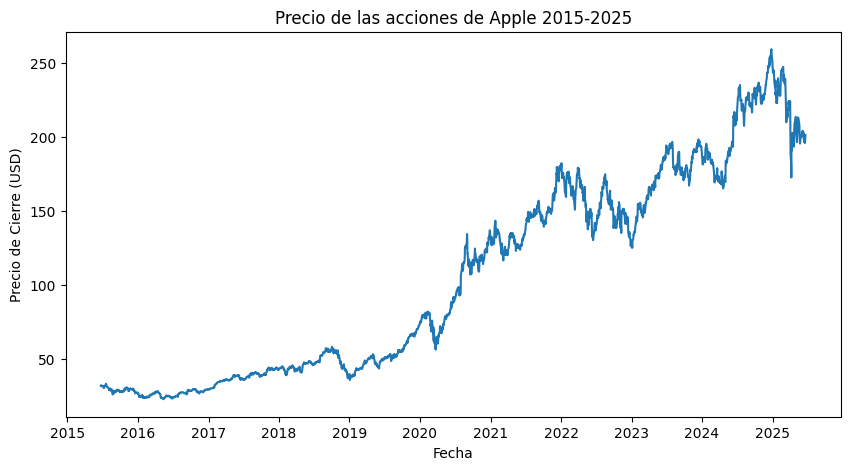

In [4]:
graficos.evolucion_cotizacion()

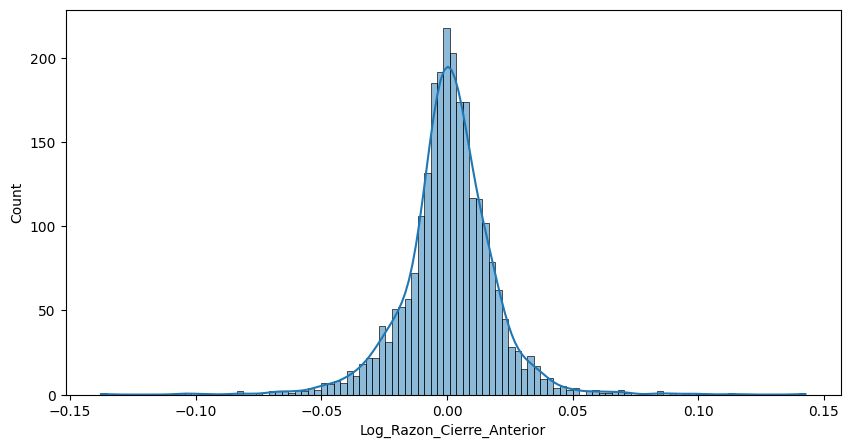

In [5]:
graficos.log_razon_cierres()

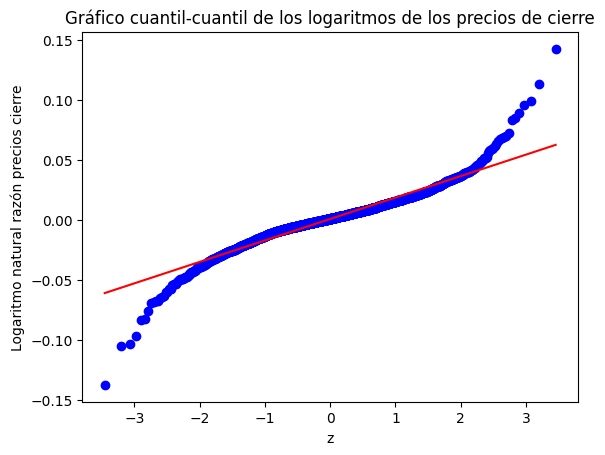

In [6]:
graficos.qq_log_razon_cierres()

In [10]:
prior_mean = df["Log_Razon_Cierre_Anterior"].mean()
prior_sd = df["Log_Razon_Cierre_Anterior"].std()
print(prior_mean, prior_sd)


0.0007321481827498323 0.018527200736851615


In [24]:
with pm.Model() as model_prior_info:
    # a priori
    mu = pm.Normal("mu", mu=prior_mean, sigma=prior_sd)
    # Verosimilitud como Normal, usando el sigma del problema
    y = pm.Normal("y", mu=mu, sigma=prior_sd, observed=df["Log_Razon_Cierre_Anterior"])
    # Muestreo del Posterior
    data_prior_info = pm.sample(chains=4, random_seed=seed)
    # Agregar el prior a idata4 (Necesario para calcular el Factor de Bayes)
    data_prior_info.extend(pm.sample_prior_predictive(8000, random_seed=seed))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


/home/nadia/dev/unsl-bayes-stock/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [mu, y]


array([[<Axes: title={'center': 'mu'}>,
        <Axes: title={'center': 'mu'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

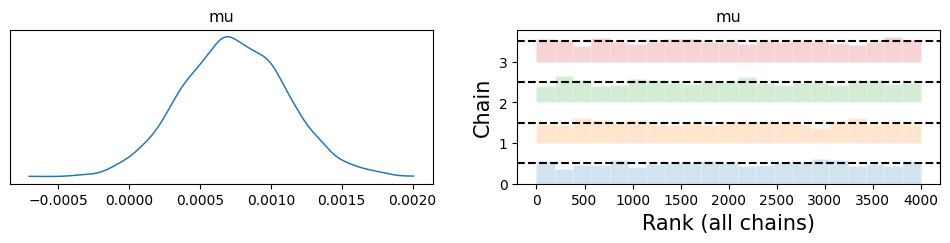

In [23]:
az.plot_trace(data_prior_info, kind="rank_bars", combined=True)

In [13]:
az.summary(data_prior_info, hdi_prob=0.95, round_to=4)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.0007,0.0004,-0.0,0.0014,0.0,0.0,1915.1242,2873.268,0.9995


In [14]:
data_prior_info.posterior["mu"].var().values

array(1.3571444e-07)

In [16]:
posterior_mu = data_prior_info.posterior["mu"].values.flatten()

# Definir el valor bajo la hipótesis nula (el límite)
h0_value = 0
prob_mu_less_than_h0 = np.mean(posterior_mu < h0_value)

print(f"Probabilidad posterior de que mu < {h0_value}: {prob_mu_less_than_h0:.4f}")

Probabilidad posterior de que mu < 0: 0.0220


In [17]:
# Extraer las muestras del prior de mu
prior_mu = data_prior_info.prior["mu"].values.flatten()
# Calcular la probabilidad prior de que mu sea menor que h0_value
prob_mu_less_than_h1 = np.mean(prior_mu < h0_value)
print(f"Probabilidad prior de que mu < {h0_value}: {prob_mu_less_than_h1:.4f}")

Probabilidad prior de que mu < 0: 0.4864


In [18]:
bf10 = prob_mu_less_than_h0 / prob_mu_less_than_h1
print(f"Factor de Bayes (BF10): {bf10:.4f}")

Factor de Bayes (BF10): 0.0452


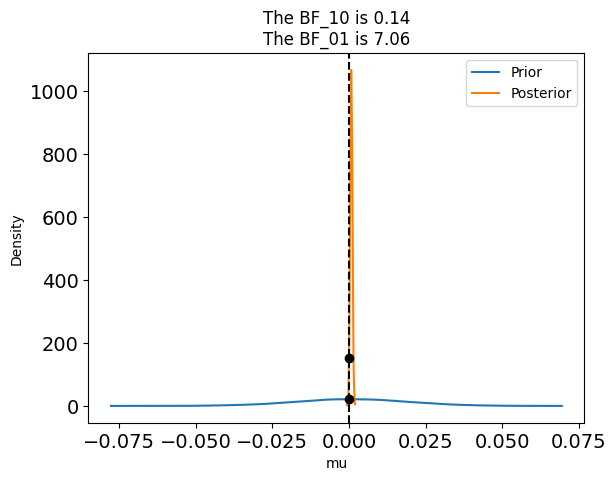

In [19]:
bf_dict, ax = az.plot_bf(data_prior_info, var_name="mu", ref_val=0);

<Axes: title={'center': 'mu'}>

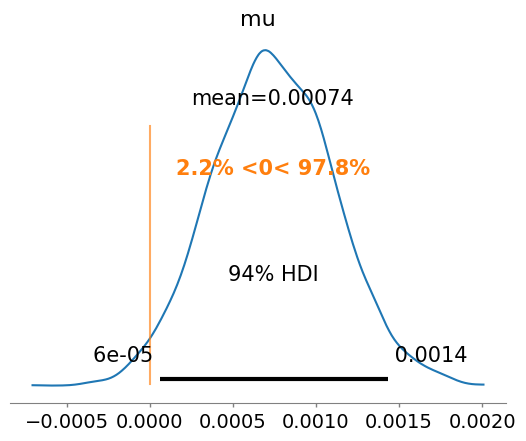

In [20]:
az.plot_posterior(data_prior_info, var_names=['mu'], ref_val=0)

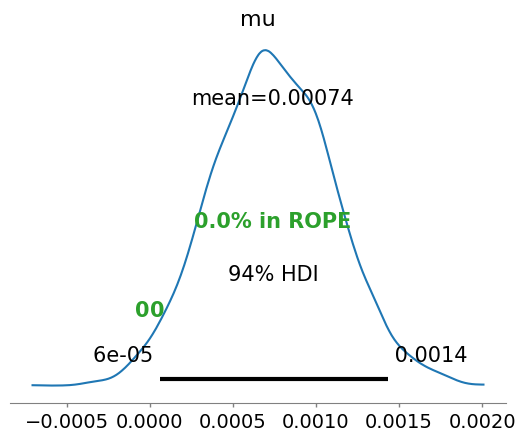

In [21]:
# Graficamos la distribución posterior de mu, marcando la región de probabilidad de H0
# rope : tiene los valores inferior y superior de la Región de Equivalencia Práctica (Region Of Practical Equivalence)
max_rope = data_prior_info.posterior["mu"].values.max().round(2)# Establecemos un máximo para ROPE según el posterior
prob_h0_az = az.plot_posterior(data_prior_info, var_names=['mu'], rope=[0, max_rope])

In [5]:
with pm.Model() as model4:
    # a prioris NO IFORMATIVO
    mu = pm.Uniform("mu", lower= -3, upper=3)
    sigma = pm.HalfNormal("sigma", sigma=1)
    # Verosimilitud como Normal
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=df["Log_Razon_Cierre_Anterior"])
    # Muestreo del Posterior
    idata4 = pm.sample(2000, chains=4, random_seed=seed, target_accept=0.95)
    # Agregar el prior a idata4 (Necesario para calcular el Factor de Bayes)
    idata4.extend(pm.sample_prior_predictive(8000, random_seed=seed))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/nadia/dev/unsl-bayes-stock/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [mu, sigma, y]


array([[<Axes: title={'center': 'mu'}>,
        <Axes: title={'center': 'mu'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

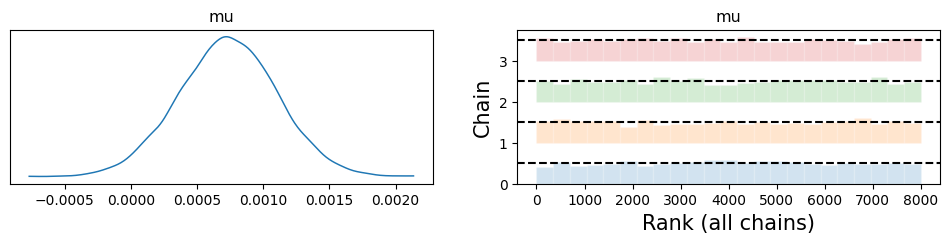

In [7]:
az.plot_trace(idata4, kind="rank_bars", combined=True, var_names=["mu"])

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

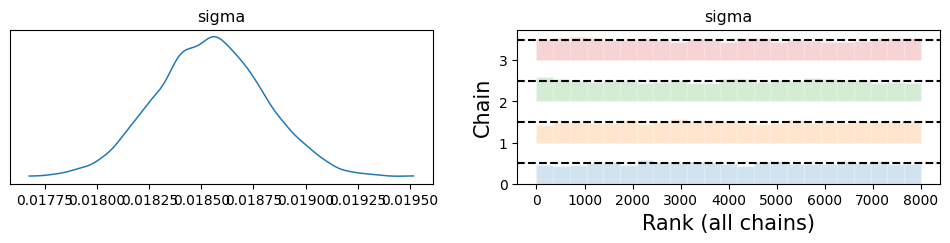

In [8]:
az.plot_trace(idata4, kind="rank_bars", combined=True, var_names=["sigma"])